In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns                              #Seaborn is a library for making statistical graphics in Python.
import statsmodels.api as sm
from Visualization import give_data
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from sklearn.metrics import r2_score
import warnings 
warnings.filterwarnings("ignore")

data_all = give_data(['Source', 'Month', 'Brand', 'Model', 'SALES THS.USD']) #read and process
data_all = data_all[data_all['Source'] == 'Traditional Sales']  #take only Traditional Sales
data_all = data_all[data_all['Brand'] == 'SAMSUNG']

In [2]:
data = data_all[data_all['Model'] == 'RB37J5000SA/UA']
data.head()

,Source,Month,Brand,Model,SALES THS.USD
3,Traditional Sales,2018-01-01,SAMSUNG,RB37J5000SA/UA,297.090130
1709,Traditional Sales,2018-02-01,SAMSUNG,RB37J5000SA/UA,290.733918
3290,Traditional Sales,2018-03-01,SAMSUNG,RB37J5000SA/UA,388.535457
4918,Traditional Sales,2018-04-01,SAMSUNG,RB37J5000SA/UA,361.447581
6592,Traditional Sales,2018-05-01,SAMSUNG,RB37J5000SA/UA,476.815415


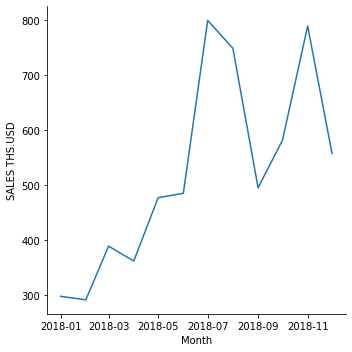

In [3]:
sns.relplot(x='Month', y='SALES THS.USD',kind='line', data=data) #visualization

In [4]:
otg = data[['Month', 'SALES THS.USD']]# обрабатываем
otg = otg.set_index('Month')
otg.index = otg.index.to_period(freq='M')
itog = otg.describe()
itog

,SALES THS.USD
count,12.000000
mean,522.655968
std,180.137389
min,290.733918
25%,381.763488
50%,489.869428
75%,623.401447
max,799.944728


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103775F0>]],
      dtype=object)

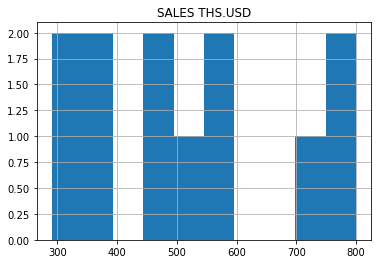

In [5]:
otg.hist()

In [6]:
res = []#поиск параметра для SimpleExpSmoothing
for i in range(1000):
    fit3 = SimpleExpSmoothing(otg).fit(smoothing_level=i/1000,optimized=False)
    res += [[i/1000, ((otg['SALES THS.USD']- fit3.fittedvalues)**2).sum()]] #среднеквадр отклонение
res = sorted(res, key=lambda x: x[1])
print(res[0])

[0.578, 261318.8765546929]


In [7]:
res = []#поиск параметра для Holt
for i in range(100):
    for j in range(100):
        fit3 = Holt(otg).fit(smoothing_level=j/100, smoothing_slope=i/100)
        res += [[[j/100, i/100], fit3.aic]]  
res = sorted(res, key=lambda x: x[1])
print(res[0])

[[0.01, 0.0], 122.39607285435179]


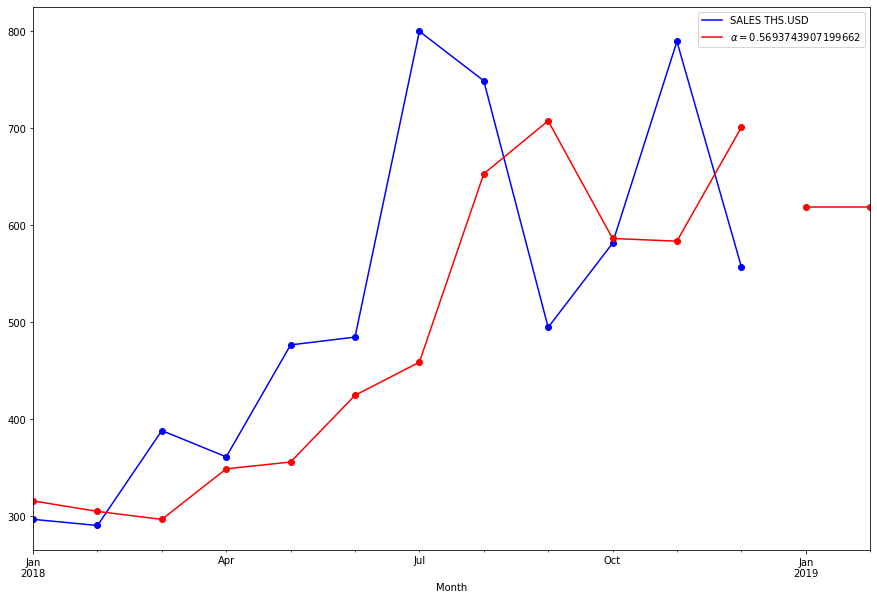

In [8]:
#прогноз за допомогою SimpleExpSmoothing
fit1 = SimpleExpSmoothing(otg).fit()
fcast1 = fit1.forecast(2).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])
ax = otg.plot(marker='o', color='blue', figsize=(15,10))
fcast1.plot(marker='o', ax=ax, color='red', legend=True) #то что прогнозируется 
fit1.fittedvalues.plot(marker='o', ax=ax, color='red') #то что обучилось
plt.show()

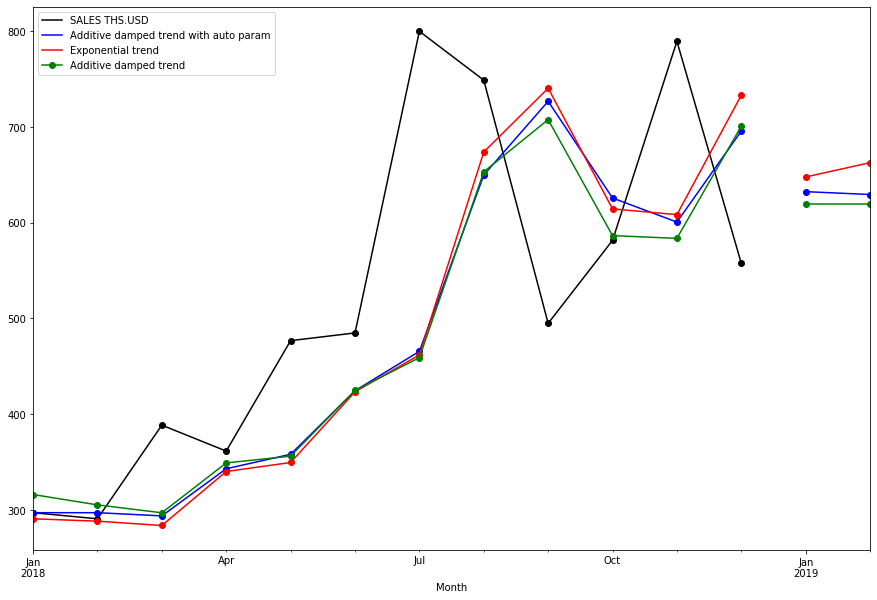

In [9]:
fit1 = Holt(otg, damped=True).fit()
fcast1 = fit1.forecast(2).rename("Additive damped trend with auto param")
#print(fit1.aic)
fit2 = Holt(otg, exponential=True).fit(smoothing_level=0.5693, smoothing_slope=0.053, optimized=False)
fcast2 = fit2.forecast(2).rename("Exponential trend")
#print(fit2.aic)
fit3 = Holt(otg, damped=True, exponential=True).fit()
fcast3 = fit3.forecast(2).rename("Additive damped trend")
#print(fit3.aic)                                         #показывает какой более точный
ax = otg.plot(marker='o', color='black', figsize=(15,10))
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)
plt.show()

In [10]:
fit1 = SimpleExpSmoothing(otg).fit()
fit2 = Holt(otg).fit()
fit3 = Holt(otg,exponential=True).fit()
fit4 = Holt(otg,damped=True).fit()
fit5 = Holt(otg,exponential=True,damped=True).fit()
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'initial_level', 'initial_slope']
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE"] ,columns=['SES', "Holt's","Exponential", "Additive", "Multiplicative"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse]            #sse ср кв ошибка
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] =       [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]              
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,0.569374,2.443758e-13,0.018429,0.421053,5.693749e-01
$\beta$,NaN,1.197637e-14,0.000000,0.421053,0.000000e+00
$\phi$,NaN,NaN,NaN,0.578947,0.000000e+00
$l_0$,316.052741,2.842386e+02,297.090086,297.090130,3.160517e+02
$b_0$,NaN,3.667286e+01,1.073475,0.000000,inf
SSE,260905.058260,1.640624e+05,201567.657223,259265.020607,2.609051e+05


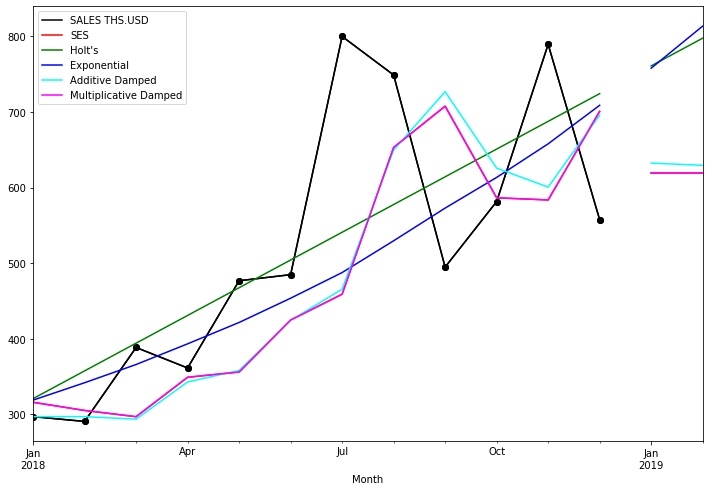

In [11]:
fit1 = SimpleExpSmoothing(otg).fit()
fcast1 = fit1.forecast(2).rename("SES")
fit2 = Holt(otg).fit()
fcast2 = fit2.forecast(2).rename("Holt's")
fit3 = Holt(otg, exponential=True).fit()
fcast3 = fit3.forecast(2).rename("Exponential")
fit4 = Holt(otg, damped=True).fit()
fcast4 = fit4.forecast(2).rename("Additive Damped")
fit5 = Holt(otg, exponential=True, damped=True).fit()
fcast5 = fit5.forecast(2).rename("Multiplicative Damped")

ax = otg.plot(color="black", marker="o", figsize=(12,8))
otg.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color='red', legend=True)
fit1.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='green', legend=True)
fit2.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='blue', legend=True)
fit3.fittedvalues.plot(ax=ax, color='blue')
fcast4.plot(ax=ax, color='cyan', legend=True)
fit4.fittedvalues.plot(ax=ax, color='cyan')
fcast5.plot(ax=ax, color='magenta', legend=True)
fit5.fittedvalues.plot(ax=ax, color='magenta')
plt.show()

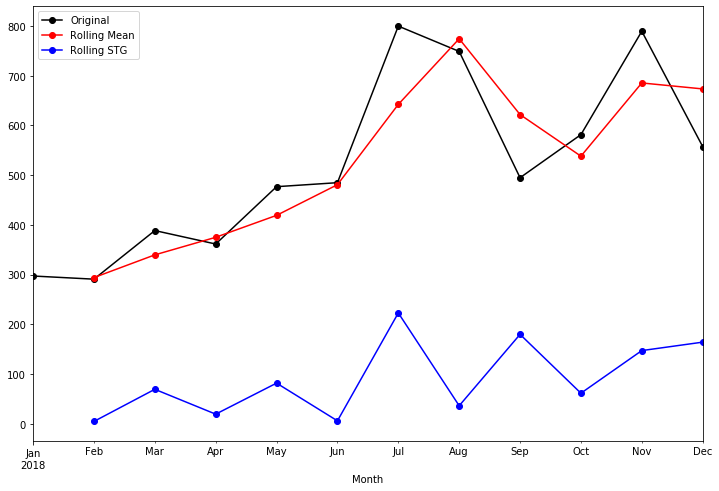

In [12]:
rolmean = otg.rolling(2).mean()                              #cкользящее среднее за два предыдущих периода
rolstd = otg.rolling(2).std()                                 #otg дисперсия
ax = otg.plot(color="black", marker="o", figsize=(12,8))
rolmean.plot(ax=ax,color="red", marker="o")
rolstd.plot(ax=ax,color="blue", marker="o")
plt.legend(['Original','Rolling Mean','Rolling STG'])

In [13]:
print('V = ' + str(itog.loc['std'][0]/itog.loc['mean'][0]))            #волотильность

V = 0.34465767161826155


In [14]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']# тест Jarque–Bera         
jb_test = sm.stats.stattools.jarque_bera(otg)  
a = [np.hstack(jb_test)]  #горизонт склеивание. 
itog = SimpleTable(a, row)   
itog                             #p-values должно быть > 0,05

JB,p-value,skew,kurtosis
0.8543138956950858,0.6523611575133034,0.3481812212416117,1.893787027698115


In [15]:
test = sm.tsa.adfuller(otg['SALES THS.USD'])#тест Дікі-Фулера
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -1.899512524773052
p-value: 0.3322904691961855
Critical values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
є одиничні корені, ряд не є стаціонарним


In [16]:
otg1diff = otg.diff(periods=1).dropna()# беремо різниці першого порядку

In [17]:
test = sm.tsa.adfuller(otg1diff['SALES THS.USD'])
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -3.5314505398036777
p-value: 0.0072151743614844365
Critical values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}
одиничних коренів нема, ряд є стаціонарним


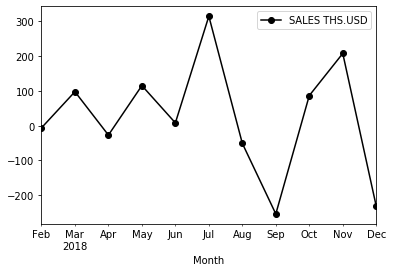

In [18]:
otg1diff.plot(color="black", marker="o")

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

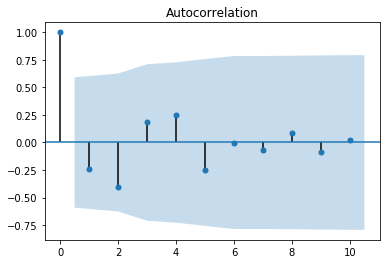

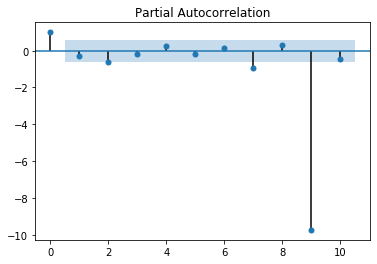

In [19]:
sm.graphics.tsa.plot_acf(otg1diff.values.squeeze()), sm.graphics.tsa.plot_pacf(otg1diff)# ACF & PACF

In [20]:
model = sm.tsa.ARIMA(otg, order=(7,1,0), freq='M').fit(full_output=False)# BUILDING A MODEL
model1 = sm.tsa.ARIMA(otg, order=(2,1,0), freq='M').fit(full_output=False)# BUILDING A MODEL

In [21]:
def evaluate_models(dataset, p_values, d_values, q_values):#search for the best model
    best_score, best_cfg = 1e9, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse =sm.tsa.ARIMA(dataset, order=order, freq='M').fit().aic
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [22]:
evaluate_models(otg, [0,1,2,3,4,5,6,7,8,9], [1], [0,1,2,3,4,5,6,7,8,9])

Best ARIMA(7, 1, 2) MSE=137.477


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.SALES THS.USD   No. Observations:                   11
Model:                 ARIMA(7, 1, 0)   Log Likelihood                 -61.334
Method:                       css-mle   S.D. of innovations             13.173
Date:                Wed, 05 Feb 2020   AIC                            140.668
Time:                        15:45:52   BIC                            144.249
Sample:                    02-28-2018   HQIC                           138.411
                         - 12-31-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    37.4179      0.834     44.849      0.000      35.783      39.053
ar.L1.D.SALES THS.USD    -1.0631      0.061    -17.424      0.000      -1.183      -0.944
ar.L2.D.SALES THS.USD    -1.4388      0.059    -24.265      0.000      -1.555      -1.323
ar.L3.D.SALES THS.USD    -1.1413      0.075    -15.275      0.001      -1.288      -0.995
ar.L4.D.SALES THS.USD    -1.1333      0.073    -15.522      0.001      -1.276      -0.990
ar.L5.D.SALES THS.USD    -1.4448      0.060    -23.953      0.000      -1.563      -1.327
ar.L6.D.SALES THS.USD    -1.0634      0.061    -17.521      0.000      -1.182      -0.944
ar.L7.D.SALES THS.USD    -0.9840        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6716           -0.7410j            1.0001           -0.1328
AR.2            0.6716           +0.7410j            1.0001            0.1328
AR.3           -1.0004           -0.0000j            1.0004           -0.5000
AR.4           -0.5916           -0.8149j            1.0070           -0.3499
AR.5           -0.5916           +0.8149j            1.0070            0.3499
AR.6           -0.1201           -0.9935j            1.0008           -0.2691
AR.7           -0.1201           +0.9935j            1.0008            0.2691
-----------------------------------------------------------------------------
"""

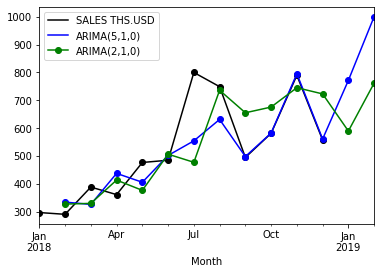

In [24]:
preds =  model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2019-02"), typ='levels').rename('ARIMA(5,1,0)')# прогноз
preds1 =  model1.predict(pd.to_datetime("2018-02"), pd.to_datetime("2019-02"), typ='levels').rename('ARIMA(2,1,0)')
ax = otg.plot(color="black", marker="o",legend=True)
preds.plot(ax=ax,color="blue", marker="o",legend=True)
preds1.plot(ax=ax,color="green", marker="o",legend=True)

In [25]:
from sklearn.metrics import r2_score        
pred = model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels')
pred1 = model1.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels')
trn = otg['2018-02':]
r2 = r2_score(trn, pred)
r2_1 = r2_score(trn, pred1)
print('R^2: %1.2f'%r2)      #determination  coefficient
print('R^2: %1.2f'%r2_1) 

R^2: 0.70
R^2: 0.38
